In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.stats
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
import time
import scipy.linalg as scilinalg
import seaborn as sns
from scipy.stats import ortho_group
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import multiprocessing as mp
from joblib import Parallel, delayed
from utils import *

from conf_simu import *

np.random.seed(1234)

/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def simu_synthetic(d1,d2,alpha,het,sd,tail,pr,k_star,rk,M_mean,mis_set,plot=False,full_exp=False):
    M_star, A, P, S = gen_(d1,d2,het,sd,tail,pr,M_mean,mis_set,k_star)
    return cfmc_simu(alpha,rk,A,S,M_star,P,het,plot,full_exp=full_exp)

coverage rate: 
	 cmc-als 0.8976351148401049
	 cmc-cvx 0.8970343819459741
	 als 0.7839364024109413
	 cvx 0.9384449027813933
Average length: 
	 cmc-als 4.1944
	 cmc-cvx 3.8953
	 als 2.994
	 cvx 4.2216


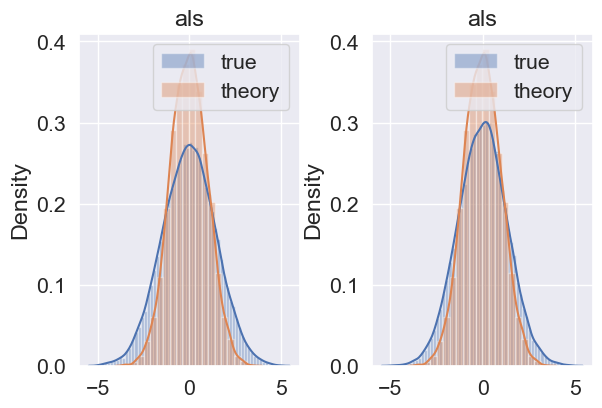

In [5]:
d1 = d2 = 500
alpha = 0.1
sd = 1
het = 'homo' # 'homo' | 'logis' | 'rank1'
pr = 0.8
rk = 40
k_star = 6
M_mean = 2
mis_set = 2
full_exp=True
tail = 'gaussian'
if full_exp:
    coverage_cmc_cvx, coverage_cmc_als, coverage_cvx, coverage_als, length_cmc_cvx, length_cmc_als, length_cvx, length_als = simu_synthetic(d1,d2,alpha,het,sd,tail,pr,k_star,rk,M_mean,mis_set,plot=True,full_exp=full_exp)
    print('coverage rate: \n\t cmc-als {}\n\t cmc-cvx {}\n\t als {}\n\t cvx {}'.format(coverage_cmc_als, coverage_cmc_cvx, coverage_als, coverage_cvx))
    print('Average length: \n\t cmc-als {}\n\t cmc-cvx {}\n\t als {}\n\t cvx {}'.format(length_cmc_als, length_cmc_cvx, length_als, length_cvx))
else:
    coverage_cmc_als, coverage_als, length_cmc_als, length_als = simu_synthetic(d1,d2,alpha,het,sd,tail,pr,k_star,rk,M_mean,mis_set,plot=True,full_exp=full_exp)
    print('coverage rate: \n\t cmc-als {}\n\t als {}'.format(coverage_cmc_als, coverage_als))
    print('Average length: \n\t cmc-als {}\n\t als {}'.format(length_cmc_als, length_als))

In [4]:
# repeated
# remember to disable plotting
alpha = 0.1
sd0 = 1
het = 'homo' # 'homo' | 'logis' | 'rank1'
base1 = 'cvx'
base2 = base = 'als'
repN = 100
M_mean = 2
k_star = 8
sigma_true=False
num_cores = mp.cpu_count()


for d in [500]:
    d1 = d2 = d
    for full_exp in [True]:
        if full_exp:
            rk_seq = range(4,25,4)
        else:
            rk_seq = range(2,41,2)
        for pr in [0.8]:
            for tail in ['gaussian']:
                for mis_set in [1]:
                    for rk in rk_seq:
                        if mis_set==2:
                            pr = 0.2
                        else:
                            pr = 0.8
                        if mis_set==3:
                            tail='t'
                            sd = 0.2
                        else:
                            tail='gaussian'
                            sd = sd0
                        print([mis_set, tail, sd])
                        if __name__ == "__main__":
                            results = Parallel(n_jobs=num_cores)(delayed(simu_synthetic)(d1,d2,alpha,het,sd,tail,pr,k_star,rk,M_mean,mis_set,full_exp=full_exp) for i in range(repN))
                        results = np.array(results)

                        if full_exp:
                            res_mat = results.reshape(repN,8)
                            cov_rt_cf_cvx = res_mat[:,0]
                            cov_rt_cf_als = res_mat[:,1]
                            cov_rt_cvx = res_mat[:,2]
                            cov_rt_als = res_mat[:,3]
                            cov_ = np.hstack((cov_rt_cf_cvx, cov_rt_cf_als))
                            cov_ = np.hstack((cov_,cov_rt_cvx))
                            cov_ = np.hstack((cov_,cov_rt_als))
                            len_ave_cf_cvx = res_mat[:,4]
                            len_ave_cf_als = res_mat[:,5]
                            len_ave_cvx = res_mat[:,6]
                            len_ave_als = res_mat[:,7]
                            len_ = np.hstack((len_ave_cf_cvx, len_ave_cf_als))
                            len_ = np.hstack((len_,len_ave_cvx))
                            len_ = np.hstack((len_,len_ave_als))

                            label1 = 'cf-'+base1
                            label2 = 'cf-'+base2
                            label3 = 'cvx'
                            label4 = 'als'
                            nam_ = [label1]*repN + [label2]*repN + [label3]*repN + [label4]*repN 
                            cov_df = pd.DataFrame(cov_, columns=['coverage'])
                            len_df = pd.DataFrame(len_, columns=['length'])
                            cov_df['approach'] = nam_
                            len_df['approach'] = nam_

                        else:
                            res_mat = results.reshape(repN,4)
                            cov_rt_cf_als = res_mat[:,0]
                            cov_rt_als = res_mat[:,1]
                            cov_ = np.hstack((cov_rt_cf_als,cov_rt_als))
                            len_ave_cf_als = res_mat[:,2]
                            len_ave_als = res_mat[:,3]
                            len_ = np.hstack((len_ave_cf_als,len_ave_als))

                            label1 = 'cf-'+base2
                            label2 = 'als'
                            nam_ = [label1]*repN + [label2]*repN
                            cov_df = pd.DataFrame(cov_, columns=['coverage'])
                            len_df = pd.DataFrame(len_, columns=['length'])
                            cov_df['approach'] = nam_
                            len_df['approach'] = nam_

                        file_dir1 = '../results/cov_'+str(d1)+'_'+str(mis_set)+'_'+str(k_star)+'_'+str(rk)+'_'+het+'_'+str(sd)+'_'+tail+'_'+str(pr)+'_'+str(full_exp)+'.csv'
                        file_dir2 = '../results/len_'+str(d1)+'_'+str(mis_set)+'_'+str(k_star)+'_'+str(rk)+'_'+het+'_'+str(sd)+'_'+tail+'_'+str(pr)+'_'+str(full_exp)+'.csv'
                        cov_df.to_csv(file_dir1, index=False)
                        len_df.to_csv(file_dir2, index=False)



[1, 'gaussian', 1]
